In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from qRNN import *

In [36]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [37]:
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return torch.Tensor(x), torch.Tensor(y)

np.random.seed(42)

In [38]:
stock_symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2024-01-01"
stock_data = download_stock_data(stock_symbol, start_date, end_date)

closing_prices = stock_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

time_steps = 5

x, y = prepare_data(closing_prices_scaled, time_steps)

split_ratio = 0.8
train_size = int(len(x) * split_ratio)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

[*********************100%%**********************]  1 of 1 completed


In [39]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return (labels - predictions) ** 2

def cost(weights, rotations, X):
    loss = 0
    for xs, label in X:
        hidden_state = torch.zeros((1,))
        for x in xs:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        loss += square_loss(label, prediction)
    
    return loss/batch_size

#train, test = dill.load(open('temperature_processed.pkl', 'rb'))

optimizer = Adam([weights, rotations], lr=0.001)

epoch = 20*10
batch_size = 500


loss_history = []

def accuracy(predicted_sequence, true_sequence):
    return 1-np.mean(np.abs( np.square((predicted_sequence - true_sequence)/true_sequence)) )

def closure():
    batch = random.choices(list(zip(x_train, y_train)), k=batch_size)
    optimizer.zero_grad()
    loss = cost(weights, rotations, batch)
    loss.backward()
    return loss

In [40]:
for i in tqdm(range(epoch)):
    loss = optimizer.step(closure)
    loss_history.append(loss.item())
    if i % 10 == 0 and i > 0:
        print(loss.item())

  0%|          | 0/200 [00:00<?, ?it/s]

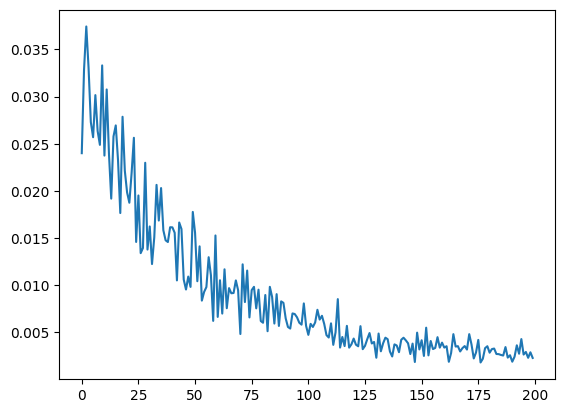

496


In [ ]:
plt.plot(loss_history)
plt.show()

print(len(x))

In [ ]:
with torch.no_grad():
    predictions = []  
    for stock in x_test:
        hidden_state = torch.zeros((1,))
        for x in stock:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        predictions.append(prediction)




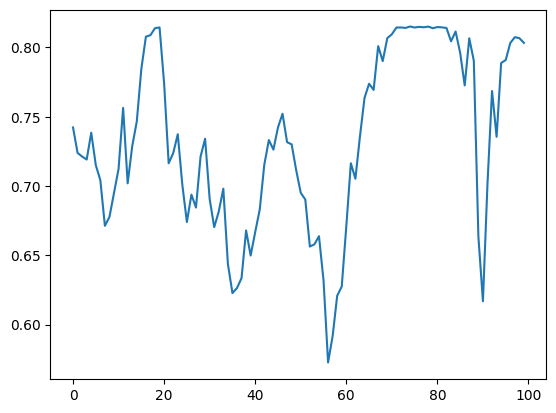

In [ ]:
plt.plot(predictions)
predictions = torch.Tensor(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

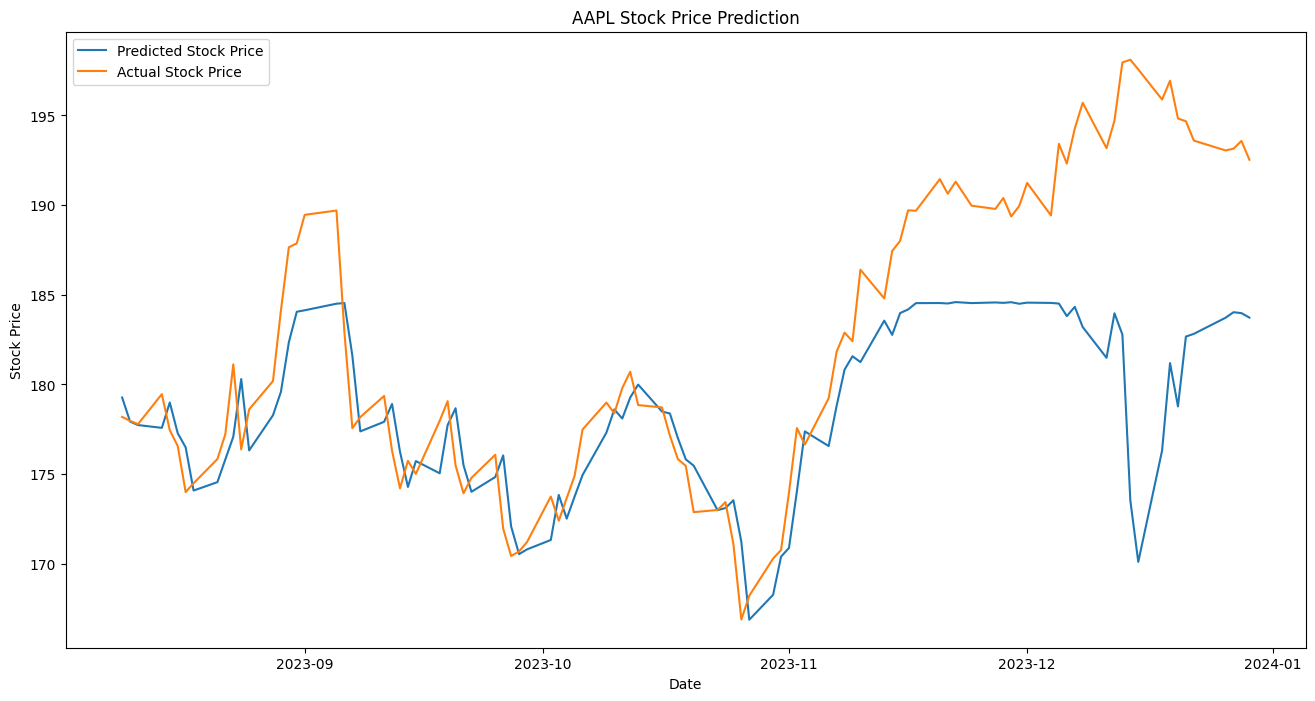

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Stock Price')
plt.plot(stock_data.index[-len(predictions):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
acc = accuracy(predictions, scaler.inverse_transform(y_test.reshape(-1, 1)))
acc

0.9987841492336308